# XGBoost modeling

##### Import libraries and data

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_score, recall_score


# import data
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")

train.drop(["fbs_1", "cp_3", "restecg_2", "thal_1", "ca_4"], axis=1, inplace=True)

val.drop(["fbs_1", "cp_3", "restecg_2", "thal_1", "ca_4"], axis=1, inplace=True)

C:\Users\zasz\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\zasz\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# 1. Split X and y

In [2]:
X = train.drop("target", axis=1)
y = train.target
cols = X.columns

X_val = val.drop("target", axis=1)
y_val = val.target

# 2. Scaling

In [3]:
sc = StandardScaler()
X = sc.fit_transform(X)
X_val = sc.transform(X_val)

X = pd.DataFrame(X, columns=cols)
X_val = pd.DataFrame(X_val, columns=cols)

# 3. Hyperparameter tuning

In [4]:
params = {
    "max_depth":[2, 3, 4, None],
    "n_estimators":[100, 150], 
    "learning_rate":[None, 0.01, 0.1]
}

gs = GridSearchCV(XGBClassifier(), param_grid=params, cv=5)
gs.fit(X, y)

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                   

In [5]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}

In [6]:
model1 = gs.best_estimator_

# Performance Metrics

In [7]:
model1.fit(X, y)
train_pred = model1.predict(X)
y_pred = model1.predict(X_val)

print("training scores")
print(classification_report(y, train_pred))
print('\n validation scores')
print(classification_report(y_val, y_pred))

training scores
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       120
           1       0.98      0.99      0.99       124

    accuracy                           0.99       244
   macro avg       0.99      0.99      0.99       244
weighted avg       0.99      0.99      0.99       244


 validation scores
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       1.00      0.68      0.81        19

    accuracy                           0.79        28
   macro avg       0.80      0.84      0.78        28
weighted avg       0.87      0.79      0.79        28



## Feature importances

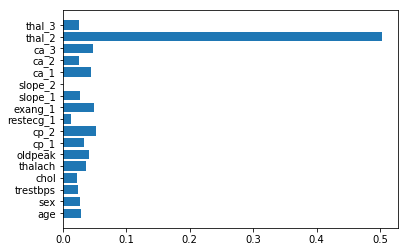

In [8]:
plt.barh(X.columns, model1.feature_importances_)
plt.show()

## Precision Recall Tradeoff

C:\Users\zasz\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


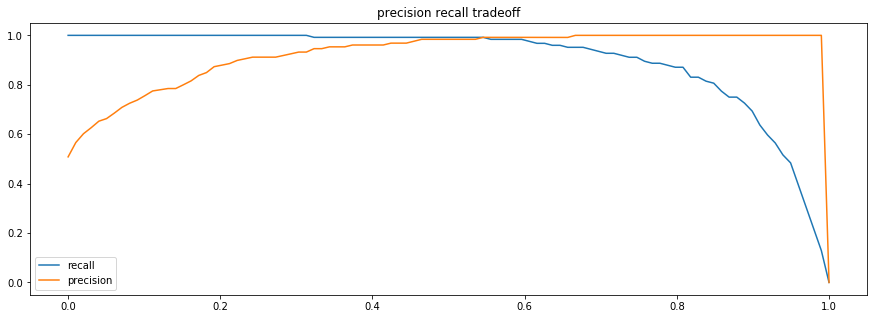

In [9]:
probs = model1.predict_proba(X)[:, 1]

thresholds = np.linspace(0, 1, 100)

precisions = []
recalls = []
for thresh in thresholds:
    predicted_vals = [1 if prob > thresh else 0 for prob in probs]
    precisions.append(precision_score(y, predicted_vals))
    recalls.append(recall_score(y, predicted_vals))

plt.figure(figsize=(15, 5))
plt.plot(thresholds, recalls, label="recall")
plt.plot(thresholds, precisions, label="precision")
plt.title("precision recall tradeoff")
plt.legend()
plt.show()

It seems the best threshold is around 0.2

In [10]:
probs = model1.predict_proba(X)[:, 1]
train_pred = [1 if prob > 0.2 else 0 for prob in probs]

probs = model1.predict_proba(X_val)[:, 1]
y_pred = [1 if prob > 0.2 else 0 for prob in probs]

print("training scores")
print(classification_report(y, train_pred))
print('\n validation scores')
print(classification_report(y_val, y_pred))

training scores
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       120
           1       0.88      1.00      0.94       124

    accuracy                           0.93       244
   macro avg       0.94      0.93      0.93       244
weighted avg       0.94      0.93      0.93       244


 validation scores
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.95      0.97        19

    accuracy                           0.96        28
   macro avg       0.95      0.97      0.96        28
weighted avg       0.97      0.96      0.96        28

